# Import Libraries

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

env = gym.make('MountainCar-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
env.close()
print(env.action_space)
print(env.observation_space)

# Helper Methods

In [3]:
## normalize functions between 0 and 1 cosine

def normalize(state):

    s0 = state[0]
    s1 = state[1]

    # s0 = x, s1 = v
    new_s0 = (s0 + 1.2) / (0.5 + 1.2)
    new_s1 = (s1 + 0.7) / (0.7 + 0.7)

    return [new_s0, new_s1]

## phi full version # size (M+1)^2 where 2 is dim of state
def get_phi_full(M, s):

    # normalize
    state = normalize(s)

    s0 = state[0] 
    s1 = state[1]

    # full fourier basis function using cosine
    phi = [1.0]

    for i in range(1, M+1):
      phi.append(np.cos(i*np.pi *s0))

    for j in range(1, M+1):
      phi.append(np.cos(j*np.pi *s1))

    for a in range(1, M+1):
      for b in range(1, M+1):
        phi.append(np.cos(np.pi *(a*s0)*(b*s1)))

    return np.array(phi)

In [4]:
def softmax(epsilon, theta, phi):

  policy = np.zeros(theta.shape[0])

  # compute theta(s,a) full
  theta_sa = theta.dot(phi)

  for i in range(theta.shape[0]):

    policy[i] = np.exp(epsilon*theta_sa[i]) / np.sum(np.exp(epsilon*theta_sa))

  #   action_set = np.array([-1,0,1])
  action_set = np.array([0,1,2])

  action = np.random.choice(action_set, p =policy)

  prob = policy[np.argwhere(action_set== action)[0][0]]

  # gradient of softmax
  grad = np.empty((0,len(phi)))

  for j in range(len(policy)):

    if action == action_set[j]:
      grad = np.vstack((grad,(1-prob) * phi))
    else:
      grad = np.vstack((grad,(-1)*(policy[j] * phi)))
  
  return action, prob, grad

# One Step Actor Critic

In [5]:
def actor_critic(N,alpha_theta, alpha_w, M1, M2, epsilon):
       
    curve_list = []
    step_list = []
    
    theta = np.zeros((3, (M1+1)**2))
    w = np.zeros(((M2+1)**2))
    
    ac_counter = 0

    for i in range(N):

#         print(i)

        # get initial state
        state = env.reset()
        gamma = 1.0

        step_counter = 0
        
        finish = False

        while finish != True and step_counter <200:
                  
            # phi softmax
            phi_soft = get_phi_full(M1,state) # change to full fourier basis

            # get action
            action, prob, grad = softmax(epsilon, theta, phi_soft)
            
            # call env step to get new env states
            new_observation = env.step(action)
            
            # next state
            next_state = new_observation[0]
            
            # next reward
            reward = new_observation[1]
            
            # goal state
            finish = new_observation[2]
            

            # phi function approx
            phi_approx = get_phi_full(M2, state) # change to full fourier basis

            # phi next state
            phi_approx_p = get_phi_full(M2, next_state) # change to full fourier basis

            # delta                                  # function aproximation 
            delta =  reward + (gamma*(w.dot(phi_approx_p))) - (w.dot(phi_approx))

            # update w
            w = w + (alpha_w * delta * phi_approx)

            # update theta
            theta = theta + (alpha_theta *delta * grad) ##### or  add theta + alpha*(delta*grad - beta ln(pi(s,a)) ) where beta is hyperparamter 0.01

            state = next_state

            ac_counter += 1
            step_counter += 1

        curve_list.append(ac_counter)
        step_list.append(step_counter)
        
    return curve_list, step_list, theta

# Graphs

0
1
2


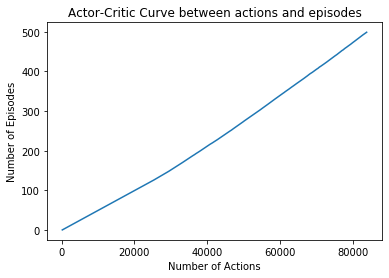

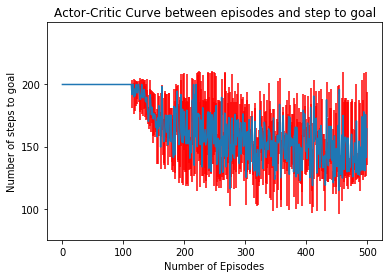

In [6]:
def graph(eps, runs):

    curve_list = []
    step_list = []
    for i in range(runs):

      print(i)

      # curve, step =  actor_critic(N, 0.5, 0.005,20,20, 0.0001) # GOOD FOR NOW
      # curve, step =  actor_critic(N, 0.05, 0.005,20,20, 0.0001) # GOOD but smaller alpha theta causes delay later
      # curve, step =  actor_critic(N, 0.5, 0.001,20,20, 0.0001) # GOOD smaller alpha w causes smaller steps
      # curve, step =  actor_critic(N, 0.5, 0.001,20,20, 0.0005)
      # curve, step =  actor_critic(N, 0.5, 0.001,20,20, 0.00005) # best.....
      curve, step, theta =  actor_critic(eps, 0.5, 0.001,30,30, 0.00005) # best ..... smaller steps at 200 episodes
      curve_list.append(curve)
      step_list.append(step)

    curve = np.mean(curve_list, axis = 0)
    step = np.mean(step_list, axis = 0)
    std_step = np.std(step_list, axis = 0)

    plt.plot(curve, range(eps))
    plt.xlabel("Number of Actions")
    plt.ylabel("Number of Episodes")
    plt.title("Actor-Critic Curve between actions and episodes")
    plt.show()

    plt.errorbar(range(eps), step, std_step, ecolor="red")
    plt.xlabel("Number of Episodes")
    plt.ylabel("Number of steps to goal")
    plt.ylim(75, 250)
    plt.yticks(range(100,250,50))
    plt.title("Actor-Critic Curve between episodes and step to goal")
    plt.show()
    
graph(500, 3)

# Run visualization on best parameters

Within actor critic method return $\theta$ so that it saves the weights thus when running mountain car it uses $\theta$, $m_1$, $ϵ$ for the softmax function

In [8]:
curve, step, theta =  actor_critic(500, 0.5, 0.001,30,30, 0.00005)

In [9]:
def run_final(theta, M1, epsilon):
    
    env = gym.make('MountainCar-v0')
    state = env.reset()
    
    done = False
    
    counter = 0

    while done != True:

        print(counter)

        # phi softmax
        phi_soft = get_phi_full(M1,state) # change to full fourier basis

        # get action
        action, _, _ = softmax(epsilon, theta, phi_soft)

        env.render()
        # get next state
        # call env step to get new env states
        new_observation = env.step(action)

        # next state
        new_state = new_observation[0]
        
        done = new_observation[2]

        #update state
        state = new_state
        
        counter += 1


    env.close()

# env.reset()
# for _ in range(1000):
#     env.render()
#     env.step(env.action_space.sample())
# env.close()





In [10]:
run_final(theta, 30, 0.00005)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
